In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry import Point, LineString
import geopandas as gpd
from matplotlib.ticker import AutoMinorLocator

In [2]:
url_template = 'https://www.ndbc.noaa.gov/view_text_file.php?filename=46042h{year}.txt.gz&dir=data/historical/stdmet/'
dfs = []
for year in range(2000, 2005):
    # file path
    url = url_template.format(year=year)
    # create df
    df = pd.read_csv(url, delim_whitespace=True, skiprows=1, header=None, names=['year', 'month', 'day', 'hour', 'wdir', 'wspd', 'gst', 'wvht', 'dpd', 'apd', 'mwd', 'pres', 'atmp', 'wtmp', 'dewp', 'vis', 'ptdy', 'tide'])
    # add the df to the empty list
    dfs.append(df)
# concatenate all the dfs into a single df
df = pd.concat(dfs, ignore_index=True)
# print the resulting df
df.head()

,year,month,day,hour,wdir,wspd,gst,wvht,dpd,apd,mwd,pres,atmp,wtmp,dewp,vis,ptdy,tide
0,2000,1,1,0,297,4.9,6.1,1.22,7.14,5.68,323,1017.4,11.0,11.6,6.5,99.0,NaN,NaN
1,2000,1,1,1,305,5.2,6.4,1.33,6.67,5.60,320,1017.6,11.1,11.7,6.7,99.0,NaN,NaN
2,2000,1,1,2,302,5.5,6.7,1.29,7.14,5.41,324,1018.1,11.2,11.6,6.7,99.0,NaN,NaN
3,2000,1,1,3,304,2.4,3.1,1.22,7.14,5.70,320,1018.1,11.3,11.6,6.6,99.0,NaN,NaN
4,2000,1,1,4,292,4.7,6.1,1.27,6.67,5.90,321,1018.5,11.5,11.6,7.2,99.0,NaN,NaN


In [3]:
#### same as above but for 2005 to 2023
dfs2 = []
for year in range(2005, 2023):
    url = url_template.format(year=year)
    df2 = pd.read_csv(url, delim_whitespace=True, skiprows=1, header=None, names=['year', 'month', 'day', 'hour', 'minute', 'wdir', 'wspd', 'gst', 'wvht', 'dpd', 'apd', 'mwd', 'pres', 'atmp', 'wtmp', 'dewp', 'vis', 'ptdy', 'tide'])
    dfs2.append(df2)
df2 = pd.concat(dfs2, ignore_index=True)
# print the 2000 - 2005 range
df2.head()

/Users/dylan/opt/anaconda3/envs/geo2023spring/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,year,month,day,hour,minute,wdir,wspd,gst,wvht,dpd,apd,mwd,pres,atmp,wtmp,dewp,vis,ptdy,tide
0,2005,1,1,0,0,216,7.4,8.6,2.8,12.9,7.83,293,1011.8,12.4,13.8,999.0,99.0,99.0,NaN
1,2005,1,1,1,0,198,8.1,9.3,2.84,12.12,7.74,292,1011.6,12.3,13.8,999.0,99.0,99.0,NaN
2,2005,1,1,2,0,206,8.4,10.1,2.94,12.9,7.62,288,1011.5,12.6,13.8,999.0,99.0,99.0,NaN
3,2005,1,1,3,0,223,8.9,10.5,2.91,12.12,7.29,298,1011.8,11.5,13.8,999.0,99.0,99.0,NaN
4,2005,1,1,4,0,215,8.4,10.9,2.77,12.9,7.16,294,1012.1,12.1,13.8,999.0,99.0,99.0,NaN


In [4]:
#### add the two different concatonated files together into variable data_list
data_list = [df, df2]
data_list = pd.concat(data_list, ignore_index=True)

In [5]:
#### Get rid of strings 
data_clean = data_list[data_list['wvht'] != 'm']

#### to datetime index 
date_cols = ['year','month','day','hour']
data_clean['time'] = pd.to_datetime(data_clean[date_cols])
data_clean.set_index('time',inplace=True)
data_clean.drop(date_cols,axis=1,inplace=True)
cols_to_drop = ['pres','atmp','dewp','vis','ptdy','tide','wspd','gst']
#### drop extra columns and drop bad sample values (99.0 or 999.0)
data_clean.drop(cols_to_drop,axis=1,inplace=True)
data_clean['wvht'] = data_clean['wvht'].astype(float)
#### more
data_clean.wdir = data_clean['wdir'].astype(float)
data_clean.mwd = data_clean['mwd'].astype(float)

/var/folders/4l/gn64yzcd6938cphmlv0bpkj80000gn/T/ipykernel_3886/645516985.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['time'] = pd.to_datetime(data_clean[date_cols])
/Users/dylan/opt/anaconda3/envs/geo2023spring/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/var/folders/4l/gn64yzcd6938cphmlv0bpkj80000gn/T/ipykernel_3886/645516985.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [6]:
data_clean.wdir = data_clean['wdir'].astype(float)
# data_clean.wdir.mean()
# data_clean.wdir.max()

In [7]:
# plt.plot(data_clean.wvht)

In [8]:
####remove bad wvht values === 99.0
data_wave = data_clean.loc[data_clean["wvht"] < 98]
# print(data_wave.shape)
#### remove wdir where values > 999.0
data = data_clean.loc[(data_clean["wdir"] < 999.0) & (data_clean["wvht"] < 98) ]
# print(data.wdir.max())

In [9]:
# plt.plot(data_wave.wvht)

In [10]:
### Convert wvht: m to ft
data_wave_ft = data_wave.wvht * 3.28084
# print(data_wave_ft)

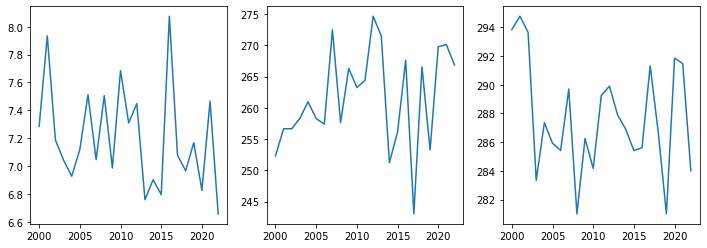

In [11]:
avg_by_year = data.groupby(data.index.year).mean()
# avg_wave_height_by_year = data.groupby('year')['wvht'].mean()
# avg_wave_height_by_month = df.groupby('month')['wvht'].mean()
# print(avg_by_year)
avg_by_year_wvht = data_wave_ft.groupby(data_wave_ft.index.year).mean()
# print(avg_by_year_wvht)
# print(avg_wave_height_by_month)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
# axs[0].plot(avg_by_year.wvht)
axs[0].plot(avg_by_year_wvht)
axs[1].plot(avg_by_year.wdir)
axs[2].plot(avg_by_year.mwd)

Text(0.5, 1.0, 'Mean Monthly (FFT Mean) Wave Direction 2000-2023')

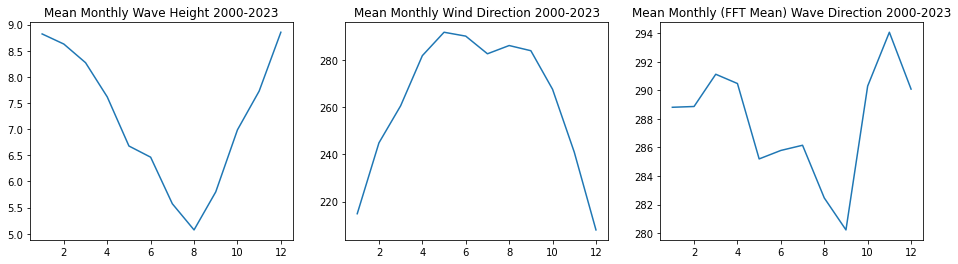

In [12]:
avg_by_month = data.groupby(data.index.month).mean()
# avg_wave_height_by_year = data.groupby('year')['wvht'].mean()
# avg_wave_height_by_month = df.groupby('month')['wvht'].mean()

# print(avg_by_month)

avg_by_month_wvht = data_wave_ft.groupby(data_wave_ft.index.month).mean()
# print(avg_by_month_wvht)
# print(avg_wave_height_by_month)

#### by month
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

axs[0].plot(avg_by_month_wvht)
axs[0].set_title('Mean Monthly Wave Height 2000-2023')
axs[1].plot(avg_by_month.wdir)
axs[1].set_title('Mean Monthly Wind Direction 2000-2023')
axs[2].plot(avg_by_month.mwd)
axs[2].set_title('Mean Monthly (FFT Mean) Wave Direction 2000-2023')

Text(0.5, 1.0, 'Mean Monthly Wave Height 2000-2023\n')

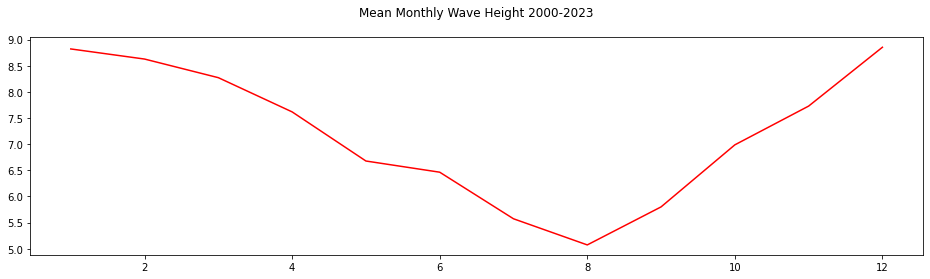

In [13]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
ax.plot(avg_by_month_wvht, color='red')
ax.set_title('Mean Monthly Wave Height 2000-2023\n')

Text(0.5, 1.0, 'Mean Yearly Wave Height 2000-2023\n')

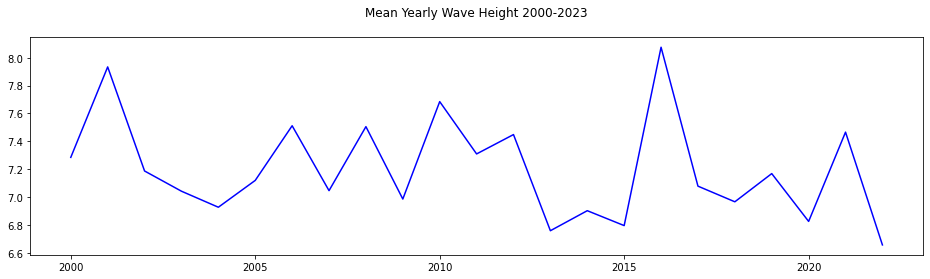

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
# axs[0].plot(avg_by_year.wvht)
ax.plot(avg_by_year_wvht,color='blue')
ax.set_title('Mean Yearly Wave Height 2000-2023\n')

Text(0.5, 1.0, 'Year vs Average Wave Height (ft)')

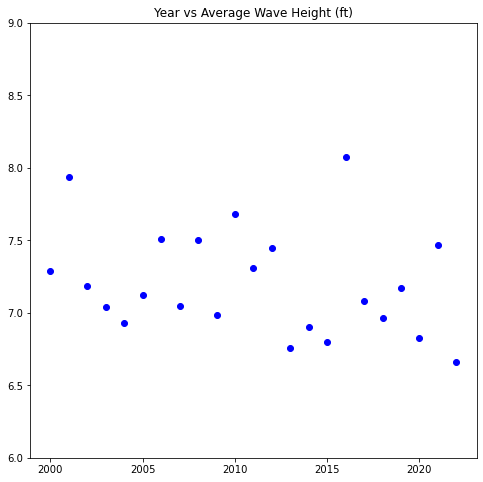

In [15]:
# avg by day isn't helpful
years = np.arange(2000,2023,1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.scatter(years, avg_by_year_wvht, marker='o',color='blue')
ax.set_ylim(6,9)
ax.set_title('Year vs Average Wave Height (ft)')

In [16]:
# number of days above 15 ft?
# data